## Libraries and import data



In [ ]:
# import the dataset from google drive:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

file_pkl = '/content/drive/My Drive/smart_app_data.pkl'

try:
  # Carica il file pkl in un DataFrame pandas
  data = pd.read_pickle(file_pkl)

except FileNotFoundError:
  print(f"Errore: Il file '{file_pkl}' non è stato trovato.")
except Exception as e:
  print(f"Si è verificato un errore: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ks_2samp
from itertools import product
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Disabilita log di TensorFlow
tf.get_logger().setLevel('ERROR')

## EDA - exploratory data analysis

In [ ]:
# Split old and new data for simulation

#h_data = load('h_data.pkl') # from data warehouse
#new_data = load('new_data.pkl') from data stream

data.head(10)

,time,asset_id,name,kpi,sum,avg,min,max
0,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,working_time,0.000000,0.000000,0.000000,0.000000
1,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,idle_time,0.000000,0.000000,0.000000,0.000000
2,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,offline_time,0.000000,0.000000,0.000000,0.000000
3,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,consumption,0.066106,0.002321,0.000000,0.066106
4,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,power,NaN,0.003673,0.000000,0.012801
5,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,consumption_working,0.062370,0.006678,0.000005,0.015817
6,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,consumption_idle,0.003736,0.000195,0.000000,0.001473
11,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,cost,0.000000,0.000645,0.000000,0.000000
12,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,cost_working,0.000000,0.000000,0.000000,0.000000
13,2024-03-01T00:00:00Z,ast-yhccl1zjue2t,Large Capacity Cutting Machine 1,cost_idle,0.000000,0.000000,0.000000,0.000000


In [ ]:
# UNDERSTANDING THE DATASET

# n and type of kpi
kpi = data['kpi'].unique()
print('the simple kpi are', np.shape(data['kpi'].unique())[0], 'and they are: \n', kpi, '\n')
# n of machines
print('there are', np.shape(data['name'].unique())[0], 'machines')
# n of days
print('the data collected has', np.shape(data['time'].unique())[0], 'days')

the simple kpi are 14 and they are: 
 ['working_time' 'idle_time' 'offline_time' 'consumption' 'power'
 'consumption_working' 'consumption_idle' 'cost' 'cost_working'
 'cost_idle' 'cycles' 'good_cycles' 'bad_cycles' 'average_cycle_time'] 

there are 16 machines
the data collected has 233 days


# FEATURE STORES (mock-up)

In [ ]:
# creation of offline feature store, called FEAT_DATA

# Valori unici per ogni colonna
names = data['name'].unique()
kpis = data['kpi'].unique()
cols = ['sum', 'avg', 'min', 'max']

# Genera tutte le combinazioni possibili
combinations = list(product(names, kpis, cols))

# Crea un DataFrame a partire dalle combinazioni
feat_data = pd.DataFrame(combinations, columns=['name', 'kpi', 'col'])

# Aggiungi le altre colonne con valori casuali
feat_data['selected_f'] = np.random.choice([7, 30], len(feat_data))
feat_data['unusable_data_bool'] = np.random.choice([True, False], len(feat_data))
feat_data['inconsistencies_flag'] = np.random.choice([True, False], len(feat_data))
feat_data['h_trend_drift'] = np.random.normal(0, 1, len(feat_data))

decompositions = []
for _ in range(len(feat_data)):
    trend = np.random.rand(233)  # Trend fittizio
    seasonal = np.random.rand(233)  # Seasonal fittizio
    residuals = np.random.rand(233)  # Residuals fittizio
    decompositions.append({
        'trend': trend,
        'seasonal': seasonal,
        'residuals': residuals
    })
feat_data['best_decomposition'] = decompositions

# Aggiungi la colonna count_miss_values con vettori di 10 zeri
feat_data['count_miss_values'] = [np.zeros(10).tolist() for _ in range(len(feat_data))]
feat_data['time_series'] = [np.random.rand(233) for _ in range(len(feat_data))]

# Mostra le prime righe del DataFrame
feat_data.head()

,name,kpi,col,selected_f,unusable_data_bool,inconsistencies_flag,h_trend_drift,best_decomposition,count_miss_values,time_series
0,Large Capacity Cutting Machine 1,working_time,sum,7,False,False,0.915455,"{'trend': [0.9707351210246178, 0.3412334281102...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2684095547971771, 0.6071647011896312, 0.116..."
1,Large Capacity Cutting Machine 1,working_time,avg,7,True,False,-1.994103,"{'trend': [0.823326211848834, 0.10082826856029...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.24025380661827678, 0.28845520365872646, 0.2..."
2,Large Capacity Cutting Machine 1,working_time,min,7,False,True,0.936679,"{'trend': [0.45318293148097677, 0.376212551045...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.38605403335959554, 0.20175736826206703, 0.4..."
3,Large Capacity Cutting Machine 1,working_time,max,30,True,True,0.277751,"{'trend': [0.4722839789884493, 0.3162549835426...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5959564077507566, 0.12153087343034286, 0.73..."
4,Large Capacity Cutting Machine 1,idle_time,sum,30,True,False,-1.835556,"{'trend': [0.71486365831397, 0.164395774101235...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.17562111941037095, 0.3964007012467038, 0.21..."


In [ ]:
# CREATION OF ONLINE FEATURE STORE, CALLED FEAT_s_DATA
from itertools import product

# Valori unici per ogni colonna
names = data['name'].unique()
kpis = data['kpi'].unique()
cols = ['sum', 'avg', 'min', 'max']

# Genera tutte le combinazioni possibili
combinations = list(product(names, kpis, cols))

# Crea un DataFrame a partire dalle combinazioni
feat_s_data = pd.DataFrame(combinations, columns=['name', 'kpi', 'col'])

# Aggiungi le altre colonne con valori casuali
feat_s_data['current_value'] = np.random.normal(0, 1, len(feat_data))
feat_s_data['predicted_value'] = np.random.normal(0, 1, len(feat_data))
# feat_s_data['iso_forest'] = [iso_forest for _ in range(len(feat_data))] # commented because iso_forest still not defined at this point
# feat_s_data['trained_ffnn'] = [trained_ffnn for _ in range(len(feat_data))] # commented because traine_ffnn still not defined at this point
# feat_s_data['scaler'] = [scaler for _ in range(len(feat_data))] # commented because scaler still not defined at this point
feat_s_data['trend_drift'] = [(bool(np.random.choice([0, 1])), round(np.random.uniform(-1, 1), 4)) for _ in range(len(feat_data))]
feat_s_data['anomalies'] = [np.random.rand(233) for _ in range(len(feat_data))]

# Mostra le prime righe del DataFrame
feat_s_data.head()

,name,kpi,col,current_value,predicted_value,trend_drift,anomalies
0,Large Capacity Cutting Machine 1,working_time,sum,0.603392,-0.706197,"(True, -0.5862)","[0.9658771584304298, 0.6787948458055433, 0.594..."
1,Large Capacity Cutting Machine 1,working_time,avg,0.317554,0.855184,"(True, -0.3802)","[0.08178033373684945, 0.9016526019810127, 0.30..."
2,Large Capacity Cutting Machine 1,working_time,min,-0.221099,0.954843,"(False, -0.1769)","[0.09834919735504477, 0.012941032445361711, 0...."
3,Large Capacity Cutting Machine 1,working_time,max,0.289030,1.840870,"(False, 0.9609)","[0.8018810334133216, 0.48660408646911146, 0.92..."
4,Large Capacity Cutting Machine 1,idle_time,sum,-0.046681,0.159091,"(False, -0.3427)","[0.465636451467505, 0.35493975724344007, 0.369..."


# Preprocessing

## Functions' definition

In [ ]:
# functions for integrating with other groups

# send warning
def send_warning(label, description):
  if label == 'Invalid data':
    print(description) ## ask which group!
  elif label == 'Ex_inconsistency':
    print(description) ## ask which group!
  elif label == 's_missing_data':
    print(description) ## ask which group!
  elif label == 'Positive_trend_drift':
    print(description) ## ask which group!
  elif label == 'Negative_trend_drift':
    print(description) ## ask which group!
  elif label == 'Anomaly_streaming':
    print(description) ## ask which group!
  else:
    print(description) ## ask which group!
  return None

# Send preprocessed data and extracted features
def send_preprocessed_data(time_series):
  # load(current_data, database_warehouse)
  return None


In [ ]:
def check_invalid_data(data):
    """
    Checks and updates data for consistency checks.
    Parameters:
    - data: DataFrame with KPI data.
    """
    for name in data['name'].unique():
        for time in data['time'].unique():

            # Check cycle
            try:
                good_cycles = data[(data['time'] == time) & (data['name'] == name) & (data['kpi'] == 'good_cycles')]['sum'].values[0]
                cycles = data[(data['time'] == time) & (data['name'] == name) & (data['kpi'] == 'cycles')]['sum'].values[0]
                bad_cycles = data[(data['time'] == time) & (data['name'] == name) & (data['kpi'] == 'bad_cycles')]['sum'].values[0]
                if cycles != good_cycles + bad_cycles:
                    send_warning('Invalid data', f'Inconsistency for {name} at {time}: cycle rule not respected.')
                    data.loc[(data['time'] == time) & (data['name'] == name) & (data['kpi'].isin(['good_cycles', 'bad_cycles', 'cycles'])), 'sum'] = np.NaN
            except IndexError:
                print(f'Missing data for {name} at {time} (cycle rule)')

            # Check energy consumption
            try:
                consumption_working = data[(data['time'] == time) & (data['name'] == name) & (data['kpi'] == 'consumption_working')]['sum'].values[0]
                consumption = data[(data['time'] == time) & (data['name'] == name) & (data['kpi'] == 'consumption')]['sum'].values[0]
                consumption_idle = data[(data['time'] == time) & (data['name'] == name) & (data['kpi'] == 'consumption_idle')]['sum'].values[0]
                if consumption != consumption_idle + consumption_working:
                   send_warning('Invalid data', f'Inconsistency for {name} at {time}: consumption rule not respected.')
                   data.loc[(data['time'] == time) & (data['name'] == name) & (data['kpi'].isin(['consumption_working', 'consumption_idle', 'consumption'])), 'sum'] = np.NaN
            except IndexError:
                print(f'Missing data for {name} at {time} (consumption rule)')

            # Check costs
            try:
                cost_working = data[(data['time'] == time) & (data['name'] == name) & (data['kpi'] == 'cost_working')]['sum'].values[0]
                cost = data[(data['time'] == time) & (data['name'] == name) & (data['kpi'] == 'cost')]['sum'].values[0]
                cost_idle = data[(data['time'] == time) & (data['name'] == name) & (data['kpi'] == 'cost_idle')]['sum'].values[0]
                if cost != cost_idle + cost_working:
                    send_warning('Invalid data', f'Inconsistency for {name} at {time}: cost rule not respected.')
                    data.loc[(data['time'] == time) & (data['name'] == name) & (data['kpi'].isin(['cost_working', 'cost_idle', 'cost'])), 'sum'] = np.NaN
            except IndexError:
                print(f'Missing data for {name} at {time} (cost rule)')

            # other possible inconsistency rules
            # try:
              # inconsistency rule
            # except

    return None



In [ ]:
def handle_missing_values(time_series, card_imputation = 5):
    """
    Handle missing values in a Pandas Series. If the missing ratio exceeds 15%,
    replaces all values with "NaN". Otherwise, fills missing values with
    the mean of the previous 5 valid values.

    Parameters:
    - time_series: Pandas Series with the KPI time series data.
    - card_imputation: Number of previous values used for imputation

    Returns:
    - Updated time_series: Series with missing values handled.
    """

    # Calculate the percentage of missing values
    missing_ratio = time_series.isnull().sum() / len(time_series)
    unusable_data_bool = False

    if missing_ratio > 0.15:
        print(f'The time series has more than 15% of missing values. Replaced with "NaN".')
        time_series[:] = np.nan
        unusable_data_bool = True
    else:
        # Handle each missing value individually
        for i in time_series.index:
            if pd.isnull(time_series.at[i]):
                print(f'Found missing value at index {i}.')

                # Get the last 5 valid values before the current index
                recent_values = time_series[:i].dropna().tail(card_imputation)

                if len(recent_values) > 0:  # Ensure there are enough valid values
                    mean_value = recent_values.mean()
                    time_series.at[i] = mean_value
                else:
                    print(f'Not enough data to calculate the mean for the missing value at index {i}.')

    return unusable_data_bool, time_series


In [ ]:
def handle_missing_values_s(value, time_series, count_miss_values, card_imputation = 5): # time series preprocessed
    """
    Handle missing values in a Pandas Series. If the missing ratio exceeds 15%,
    replaces all values with "Nan". Otherwise, fills missing values with
    the mean of the previous 5 valid values.

    Parameters:
    - time_series: Pandas Series with the KPI time series data.
    - count_miss_values: Counter for missing values
    - value: Value to be processed
    - card_imputation: Number of previous values used for imputation

    Returns:
    - Updated time_series: Series with missing values handled.
    """

    count_miss_values = np.delete(count_miss_values,0)

    # If the input value is a Pandas Series, convert it to a NumPy array
    if isinstance(value, pd.Series):
        value = value.to_numpy()

    # If the input value is a scalar, convert it to a NumPy array
    if np.isscalar(value):
        value = np.array([value])

    if not np.isnan(value)[0]: # the data is present
      time_series = pd.concat([time_series, pd.Series(value)], ignore_index=True)
      count_miss_values = np.append(count_miss_values,0)
    else: # the data is missing
      count_miss_values = np.append(count_miss_values,1)
      recent_values = time_series.tail(card_imputation)
      if len(recent_values) > 0:
        missing_ratio = count_miss_values.mean()
        if missing_ratio > 0.25:
          send_warning('s_missing_data',f'Anomalous increase in missing data')
          time_series = pd.concat([time_series, pd.Series([np.nan])], ignore_index=True)
        else:
          mean_value = recent_values.mean()
          time_series = pd.concat([time_series, pd.Series(mean_value)], ignore_index=True)
      else:
        print(f'Not enough data to calculate the mean for the missing value.')

    return time_series, count_miss_values

In [ ]:
def analysis_seasonality(time_series, freq = [7, 30], plot_flag = None):
    """
    Analyzes the seasonality of a time series for a specific machine and KPI.
    Parameters:
    - time_series: Pandas Series with the KPI time series data.
    - freq: List of seasonality frequencies to analyze.
    - plot_flag: Flag to decide whether to plot the results.

    Returns:
    - best_decomposition: Best seasonal decomposition object.
    - selected_f: Selected seasonality frequency.
    """

    # Set time as the index
    time_series = time_series.values

    # Compute the total series variance
    total_variance = np.var(time_series)

    # cycle for different seasonality freq
    best_seas_contribuition = 0
    best_decomposition = None
    selected_f = None

    for f in freq:

      # Check if there is enough data
      if len(time_series) < f:
        print(f"Not enough data to analyze seasonality (at least {f} points are required).")
      else:
        # Perform seasonal decomposition
        decomposition = seasonal_decompose(time_series, model='additive', period=f)

        # Compute the seasonal contribution
        if total_variance == 0:
          seas_contribuition = 0
        else:
          seas_contribuition = np.var(decomposition.seasonal) / total_variance
        if seas_contribuition >= best_seas_contribuition:
          selected_f = f
          best_decomposition = decomposition
          best_seas_contribuition = seas_contribuition

    # print(f"Best selected seasonality is: {selected_f}")
    # Plot the results
    if plot_flag == True:
      best_decomposition.plot()
      plt.suptitle(f'Additive Model - Seasonality for {selected_f}', fontsize=12, y=1.02)
      plt.show()

    return best_decomposition, selected_f

# Multiplicative Model cannot be implemented if there are zeros in the data.
# One can possibly add a bias to the series, apply a log transformation or eventually filter out zero data but this can
# induce possible misinterpretations--> Hockam's razor


In [ ]:
# Perform a statistical analysis
def perform_stat_analysis(time_series):
    """
    Perform statistical analysis to compute quartiles for a single time series.

    Parameters:
    - time_series: time series of data for specific machine, kpi and column
    - seasonality_info: Additional info about seasonality (optional, not used here).

    Returns:
    - A dictionary with quartile values.
    """

    if time_series.empty:
        print(f"No data available for the time series.")
    else:

      # Compute quartiles
      q1 = time_series.quantile(0.25)  # 1st quartile
      q2 = time_series.quantile(0.50)  # 2nd quartile (median)
      q3 = time_series.quantile(0.75)  # 3rd quartile
      q4 = time_series.max()           # Max value (end of the 4th quartile)

      # Construct the result dictionary
      data_parameters = {
          "min": time_series.min(),
          "Q1": q1,
          "Q2": q2,
          "Q3": q3,
          "Q4": q4,
          "Mean": time_series.mean(),
          "Std": time_series.std() ## we can add the parameters desired here
      }

      print(f"Data parameters for the time series are: {data_parameters}")

    return data_parameters

In [ ]:
def detect_inconsistencies_exogenous(time_series, exogenous_lower_thr=None, exogenous_higher_thr=None): # note: the threshold should be conservative already
    """
    Detect inconsistencies based on exogenous thresholds.

    Parameters:
    - time_series: Pandas Series with the KPI time series data
    - exogenous_lower_thr: Lower threshold for detection (optional).
    - exogenous_higher_thr: Higher threshold for detection (optional).

    Returns:
    - inconsistencies_flag: 1 if inconsistencies are detected, 0 otherwise.
    """
    inconsistencies_flag = np.zeros(len(time_series))
    for i in range(len(time_series)):
      # Check for inconsistencies using quartiles and thresholds
      inconsistent = (
          (exogenous_lower_thr is not None and time_series.iloc[i] < exogenous_lower_thr) or
          (exogenous_higher_thr is not None and time_series.iloc[i] > exogenous_higher_thr)
      )

      if inconsistent:
          inconsistencies_flag[i] = 1
          send_warning('Ex_inconsistency', f'Found inconsistency at index {i}')

    return inconsistencies_flag


In [ ]:
def detect_trend_drift_recursive(time_series, selected_f, n = 4):
    """
    Detects trend drift by comparing the current distribution with the seasonality pattern.
    Uses statistical tests to evaluate changes in the data.

    Parameters:
    - time_series: Pandas Series with the KPI time series data.
    - selected_f: Selected seasonality frequency.
    - n: Number of iterations for trend drift detection.
    Returns:
    - trend_drift_flag: Boolean indicating if a trend drift is detected.
    """
    trend_drift_bool = False
    ks_stat = 0

        # Check if time_series is long enough for comparison
    if len(time_series) > 2*selected_f:
      i = 0
      while i < n and not trend_drift_bool:
        # Perform a Kolmogorov-Smirnov test to compare distributions
        if len(time_series) > (2+i)*selected_f:
          seasonal_values = time_series[-(2+i)*selected_f:-(1+i)*selected_f]
          ks_stat, p_value = ks_2samp(time_series[-selected_f:], seasonal_values)
          #print(f"ks_stat: {ks_stat}")
          #print(f"p_value: {p_value}")
          if p_value < 0.05:  # Threshold for detecting drift
            print("Trend drift detected!")
            trend_drift_bool = True
            # understanding in which direction there is a trend drift in the distribution
            if seasonal_values.mean() < time_series[-selected_f:].mean():
              print("Trend drift is positive")
              send_warning('Positive_trend_drift', f'Trend drift is positive')
              ks_stat = - ks_stat
            else:
              print("Trend drift is negative")
              send_warning('Negative_trend_drift', f'Trend drift is negative')
              ks_stat = - ks_stat
        i = i + 1

    return trend_drift_bool, ks_stat

# comment
# KS test works well with at least 30 samples, so remember that the dection that we find is not really reliable but can be adequate for just an alert, as we are planning to do.

In [ ]:
def historical_concept_drift(time_series, selected_f, n = 4):
  trend_drift_h = pd.DataFrame({
      "trend_drift_bool": [None] * len(time_series),  # Initialize with None or False
      "ks_stat": [np.nan] * len(time_series)          # Initialize with NaN
  })
  for i in range(len(time_series)):
    h_time_series = time_series[:i]
    trend_drift_h.loc[i,"trend_drift_bool"], trend_drift_h.loc[i,"ks_stat"] = detect_trend_drift_recursive(h_time_series, selected_f, n)
  return trend_drift_h

In [ ]:
# different type of anomalies ->
#trend drift -> for each new sample(s), (1 kpi per time!) we extract statistical parameters and perform statistical tests to detect a change in the distribution of the data wrt seasonality pattern! And/or check the residuals from seasonality analysis
  # if concept drift:
  #   send alert: something is going on! new statistical analysis

# spikes/outliers: can be done with the function: detect inefficiencies, using a similar rule to the one we are using now,  -> o	Intervalli interquartili (IQR): Valori al di fuori di Q1−1.5×IQRQ1 - 1.5 \times IQRQ1−1.5×IQR e Q3+1.5×IQRQ3 + 1.5 \times IQRQ3+1.5×IQR.
#   if concept drift:
# send alert -> like, today the machine didn't work at all: are you aware of that? is there a reason for this? like black friday kind of spikes.
#   if the user says yes -> ok, we will not use those values for the prediction
#   if the user says no or doesn't answer, -> wait to collect more samples to understand whether it is just an outlier or there is a concept drift going on.

## Example tests for the functions

In [ ]:
h_data = data
name = 'Large Capacity Cutting Machine 1'
col = 'sum'
k = 'good_cycles'
time_series = h_data.loc[(h_data['name'] == name) & (h_data['kpi'] == 'cycles'), col]
i = 0
selected_f = 7

### example concept drift

In [ ]:
time_series = pd.Series(time_series)
type(time_series)

pandas.core.series.Series

NameError: name 'n' is not defined

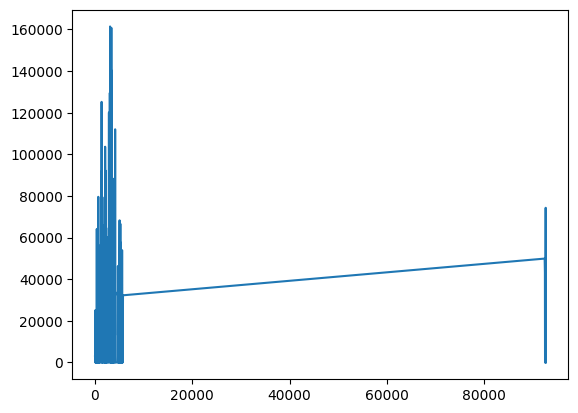

In [ ]:
# Generate a gradual trend drift for the last 4 weeks (28 days)
# Define drift parameters: Linear increase added to the last 28 samples
weeks_with_drift = 4
samples_with_drift = weeks_with_drift * selected_f
trend_drift = np.linspace(0, 2, samples_with_drift)  # Gradual increase over 4 weeks

# Add the trend drift to the last 4 weeks of the time series
time_series_with_drift = time_series.copy()
time_series_with_drift[-samples_with_drift:] += trend_drift

plt.plot(time_series_with_drift)
detect_trend_drift_recursive(time_series, selected_f, n)

In [ ]:
h_data = data
name = 'Large Capacity Cutting Machine 1'
col = 'sum'
k = 'good_cycles'
#time_series = h_data.loc[(h_data['name'] == name) & (h_data['kpi'] == 'cycles'), col]
time_series = [0.44427464460773924,
 0.2259783178374809,
 1.0153112567363451,
 1.5562780232757643,
 -0.4034718522166729,
 -0.6454194776734244,
 1.0628452142157543,
 0.6864144890720173,
 -0.07026498790861968,
 0.921281472693487,
 -0.22045467824218348,
 -0.6106000622506559,
 -0.21958338207533387,
 -2.0609355431744953,
 -1.5428134116402954,
 -0.15327958696369687,
 -0.46990267695791565,
 0.47511006597213556,
 -1.0062001302284607,
 -1.6992038493842094,
 0.9612704430294003,
 -0.20194046223852535,
 0.41004473078187587,
 -0.8383325011170264,
 -0.29287200412621095,
 -0.09482652666709686,
 -1.4654809692728752,
 -0.01361114513643602,
 -0.5372275762299467,
 0.08874684708975683,
 -0.10218173802231395,
 1.8507666805204823,
 -0.20611099180837328,
 -1.382046432036038,
 0.38606086685413876,
 -1.0919557564936664,
 0.536458946931837,
 -1.316781227228144,
 -0.9939270098417706,
 -0.01796066478453634,
 0.22450357183250919,
 -0.19636921797836135,
 -0.10343896836047967,
 0.08033033570396825,
 -0.8864292537158412,
 -0.44980952627230775,
 -0.6060465489749446,
 0.5095178463804619,
 -0.042304126834675826,
 -1.576911053781146,
 0.6395151827434787,
 0.0915729545834929,
 -0.41141873625997605,
 0.35306119782946255,
 0.4861529898682075,
 0.483316592625578,
 -0.7506189719339321,
 0.07307771159457738,
 0.7322920373913838,
 1.0665927947454372,
 -0.6226251745552134,
 -0.6020594539414372,
 -1.3391817514547673,
 -1.0699197306319677,
 1.0763908572885283,
 1.6490589760363474,
 0.1296308962310694,
 0.7035484039378406,
 -0.11254392291237053,
 -0.926658318319607,
 0.3232420562746033,
 1.7253073941489014,
 0.40395723343433376,
 1.5934985369852934,
 -2.5372099615865005,
 0.29913093130402785,
 -0.27178840362054524,
 -0.2674403045655112,
 0.4317190019502095,
 -1.341734664245128,
 -0.0024418025804243126,
 0.125372487208283,
 0.8858676020735579,
 -0.8132006438590005,
 -0.7231386621771566,
 -0.09913947470814821,
 1.2547615617317414,
 0.48808263855074985,
 -0.6678706379586175,
 0.02307933147121527,
 -0.26281686857706743,
 0.8663824179584676,
 -0.2782897083399314,
 0.14293108358165724,
 -0.15667348697443034,
 -1.5030462710439287,
 -0.17114298934711475,
 -0.11615073455801603,
 0.004573614661014621,
 0.1398245576001358,
 -0.8299450600755176,
 -0.18219790744854558,
 -0.5005718893316602,
 -1.1535796212730753,
 -0.49390399438343796,
 0.36139407288173836,
 2.036701625672968,
 0.5921481597021925,
 0.4243987795148233,
 -0.26062515831987376,
 -2.1522021652315164,
 -0.37336039949015376,
 0.053871537490885725,
 2.5528363917725003,
 0.2639481395728879,
 0.46375084935667066,
 -0.22508585767182404,
 -1.481298431331433,
 0.6725261314476965,
 0.6725493502460743,
 1.0571661507344916,
 -0.377379849762521,
 1.4487360820809685,
 -1.4478924152932706,
 0.0888999249660497,
 1.6095574040535887,
 -0.8859626228700229,
 -0.15686641920864647,
 0.5251319075147471,
 -0.25628360804826367,
 -1.5809942438345,
 -0.3746764279977478,
 -1.29979899500641,
 0.4235939474118491,
 -0.4727123668134005,
 1.8223044930740655,
 -0.5065243351060114,
 -0.48209928426874615,
 0.29163090260192154,
 -1.4505641813996473,
 0.20344635037299383,
 1.5187896902983122,
 -1.0017756971079563,
 0.3591802504502527,
 0.03840753064909966,
 0.26328261810316766,
 -1.4560080180856274,
 -1.181052299278231,
 0.8164843967504085,
 0.7016321840100883,
 0.4180863235001614,
 0.11583399184760068,
 -1.0442336184920493,
 -0.1419116463985319,
 0.26213198905194124,
 -0.2892896638625404,
 2.1048004720025473,
 0.6178477554541494,
 -1.2595729476310735,
 0.15123838295111364,
 -1.221427456770121,
 0.7039898712046375,
 1.385925057586098,
 -0.29803956374651575,
 1.0557085121561018,
 0.17516377797842994,
 0.29927194277671154,
 1.3468975510339325,
 -0.2194818033012116,
 -0.3245164518917339,
 -0.3596048756837493,
 -0.5356441945707494,
 -0.2630005723722755,
 -0.13086541442077454,
 -0.10216589392932532,
 0.7398551898774623,
 0.3612749139796213,
 1.736081418614573,
 -0.04267756093223252,
 2.2389545597176057,
 0.123612871401722,
 -1.1163106937793612,
 -0.9578353689036927,
 0.7811821154504974,
 0.23612982558808326,
 0.8326601633030762,
 0.22923789222306792,
 -0.5011411767313657,
 -1.1070409949578899,
 -1.3549205479697897,
 -0.04972944596717571,
 1.2019873849425586,
 0.38552997317276466,
 -1.3082613435627526,
 -0.2811032879162611,
 -0.005007326755286423,
 -0.7905461239057698,
 0.48714158304660904,
 0.4880644774914606,
 -0.8282650058852525,
 0.12597603669186364,
 0.06557991171565886,
 0.6190648127926418,
 0.9425492092715254,
 -0.8136137573175231,
 -0.26488416465780656,
 0.8615968060392081,
 0.5413674868154275,
 0.36949922454051815,
 3.5101352399619103,
 0.9933786165374551,
 1.9170505920233787,
 1.909975789662706,
 1.4663159265608932,
 0.2825965977631226,
 1.07042789787764,
 -0.1443298299844087,
 0.7537002401763238,
 0.9500060722717354,
 1.6126797493290137,
 3.4367460600168576,
 -0.6227921577166609,
 1.488153584997849,
 -0.41279225007114606,
 1.0261671690075698,
 2.8408740712431335,
 2.079701710428803,
 0.8852468864547067,
 0.8903121366495431,
 1.964953136905271,
 0.8591635223608245,
 2.1246409310062297,
 2.390406361103454]
selected_f= 7
n = 4
#detect_trend_drift_recursive(time_series, selected_f, n)

## Pipeline historical data

In [ ]:
# HISTORICAL DATA PREPROCESSING
def preprocess_h_data(time_series, ex_lower_thr=None, ex_higher_thr=None):

    best_decomposition, selected_f, inconsistencies_flag, h_trend_drift = None, None, None, None

    # Handling missing data and raise warning
    unusable_data_bool, time_series = handle_missing_values(time_series)

    if not unusable_data_bool:

      # seasonality analysis
      best_decomposition, selected_f = analysis_seasonality(time_series)

      # statistical analysis to extract data_parameters
      #data_parameters = perform_stat_analysis(time_series)

      # detect inconsistencies in the numerical values with respect to an exogenous threshold -> anomalies/spike
      inconsistencies_flag = detect_inconsistencies_exogenous(time_series, ex_lower_thr, ex_higher_thr)

      # detect trend drift
      h_trend_drift = historical_concept_drift(time_series, selected_f)

    return best_decomposition, selected_f, inconsistencies_flag, h_trend_drift, time_series #data_parameters

In [ ]:
# Definisci le colonne e il numero di righe
columns = ['name', 'kpi', 'col', 'ex_lower_thr', 'ex_higher_thr']
num_rows = 896

# Crea il DataFrame con valori inizializzati a None
ex_thr_matrix = pd.DataFrame(None, index=range(num_rows), columns=columns)

In [ ]:
## PIPELINE HISTORICAL DATA

h_data = data
# checking consistency rules on the whole dataset
#check_invalid_data(h_data)

# preprocessing data on single time series
for name in h_data['name'].unique():
    for k in h_data['kpi'].unique():
        for col in h_data.columns[4:]: # sum,avg,max,min
          time_series = h_data.loc[(h_data['name'] == name) & (h_data['kpi'] == k), col]
          ex_lower_thr = ex_thr_matrix[(ex_thr_matrix['name'] == name) & (ex_thr_matrix['kpi'] == k) & (ex_thr_matrix['col'] == col)]['ex_lower_thr'].iloc[0] if not ex_thr_matrix[(ex_thr_matrix['name'] == name) & (ex_thr_matrix['kpi'] == k) & (ex_thr_matrix['col'] == col)]['ex_lower_thr'].empty else None
          ex_higher_thr = ex_thr_matrix[(ex_thr_matrix['name'] == name) & (ex_thr_matrix['kpi'] == k) & (ex_thr_matrix['col'] == col)]['ex_higher_thr'].iloc[0] if not ex_thr_matrix[(ex_thr_matrix['name'] == name) & (ex_thr_matrix['kpi'] == k) & (ex_thr_matrix['col'] == col)]['ex_higher_thr'].empty else None
          best_decomposition, selected_f, inconsistencies_flag, h_trend_drift, time_series = preprocess_h_data(time_series, ex_lower_thr, ex_higher_thr)
          h_data.loc[(h_data['name'] == name) & (h_data['kpi'] == k), col] = time_series


Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected

KeyboardInterrupt: 

## Pipeline streaming data

In [ ]:
# PREPROCESSING streaming data

def preprocess_s_data(value, time_series, count_miss_values, ex_lower_thr, ex_higher_thr, selected_f): # time series preprocessed

  """ the value is the last collected value, while the time series is the relative time series for the kpi, machine, column in consideration
  """

  # Handling missing data and raise warning
  time_series, count_miss_values = handle_missing_values_s(value, time_series, count_miss_values)

  # detect inconsistencies in the numerical values -> anomalies/spike
  inconsistencies_flag = detect_inconsistencies_exogenous(value, ex_lower_thr, ex_higher_thr)

  # detect trend drift
  trend_drift = detect_trend_drift_recursive(pd.concat([time_series, pd.Series(value)], ignore_index=True), selected_f)

  return inconsistencies_flag, trend_drift, time_series, count_miss_values


In [ ]:
pp_data = data # original dataset structure preprocessed
s_data = pp_data[pp_data['time'] == '2024-10-19T00:00:00Z']

In [ ]:
# Definisci le colonne e il numero di righe
columns = ['name', 'kpi', 'col', 'ex_lower_thr', 'ex_higher_thr']
num_rows = 896

# Crea il DataFrame con valori inizializzati a None
ex_thr_matrix = pd.DataFrame(None, index=range(num_rows), columns=columns)

pp_data = data # original dataset structure preprocessed
s_data = pp_data[pp_data['time'] == '2024-10-19T00:00:00Z'] # we are taking the last day as example of streaming data
## maybe could be used the new data structure (in case change the inner cycle)

# preprocessing data on single time series
for name in pp_data['name'].unique():
    for k in pp_data['kpi'].unique():
        for col in pp_data.columns[4:]: # sum,avg,max,min
          time_series = pp_data.loc[(pp_data['name'] == name) & (pp_data['kpi'] == k), col]
          new_value = s_data.loc[(s_data['name'] == name) & (s_data['kpi'] == k), col]
          ex_lower_thr = ex_thr_matrix[(ex_thr_matrix['name'] == name) & (ex_thr_matrix['kpi'] == k) & (ex_thr_matrix['col'] == col)]['ex_lower_thr'].iloc[0] if not ex_thr_matrix[(ex_thr_matrix['name'] == name) & (ex_thr_matrix['kpi'] == k) & (ex_thr_matrix['col'] == col)]['ex_lower_thr'].empty else None
          ex_higher_thr = ex_thr_matrix[(ex_thr_matrix['name'] == name) & (ex_thr_matrix['kpi'] == k) & (ex_thr_matrix['col'] == col)]['ex_higher_thr'].iloc[0] if not ex_thr_matrix[(ex_thr_matrix['name'] == name) & (ex_thr_matrix['kpi'] == k) & (ex_thr_matrix['col'] == col)]['ex_higher_thr'].empty else None
          selected_f = feat_data[(feat_data['name'] == name) & (feat_data['kpi'] == k) & (feat_data['col'] == col)]['selected_f'].iloc[0]
          count_miss_values = feat_data[(feat_data['name'] == name) & (feat_data['kpi'] == k) & (feat_data['col'] == col)]['count_miss_values'].iloc[0]
          inconsistencies_flag, trend_drift, time_series, count_miss_values = preprocess_s_data(new_value, time_series, count_miss_values, ex_lower_thr, ex_higher_thr, selected_f)
          # values to be stored! -> offline feature store


Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected

In [ ]:
#preprocessing: example trial

# checking consistency rules
# if we can collect data from all the sensors of a single machine at the same time, we can group them into the streaming_dataset and check invalid data

s_data = data
#check_invalid_data(s_data)

time_series = data.loc[(data['name'] == "Large Capacity Cutting Machine 1") & (data['kpi'] == "cycles"), "sum"]
ex_lower_thr = None
ex_higher_thr = None

selected_f = 7
new_value_1 = np.full(1, np.nan)
new_value_2 = np.full(1, np.nan)
new_value_3 = np.full(1, np.nan)
new_value_4 = np.full(1, np.nan)
new_value_5 = np.full(1, np.nan)
count_miss_values = np.zeros(10)
inconsistencies_flag, trend_drift_bool, time_series, count_miss_values = preprocess_s_data(new_value_1, time_series, count_miss_values, ex_lower_thr, ex_higher_thr, selected_f)
inconsistencies_flag, trend_drift_bool, time_series, count_miss_values = preprocess_s_data(new_value_2, time_series, count_miss_values, ex_lower_thr, ex_higher_thr, selected_f)
inconsistencies_flag, trend_drift_bool, time_series, count_miss_values = preprocess_s_data(new_value_3, time_series, count_miss_values, ex_lower_thr, ex_higher_thr, selected_f)
inconsistencies_flag, trend_drift_bool, time_series, count_miss_values = preprocess_s_data(new_value_4, time_series, count_miss_values, ex_lower_thr, ex_higher_thr, selected_f)
inconsistencies_flag, trend_drift_bool, time_series, count_miss_values = preprocess_s_data(new_value_5, time_series, count_miss_values, ex_lower_thr, ex_higher_thr, selected_f)

Anomalous increase in missing data
Anomalous increase in missing data
Anomalous increase in missing data


# Processing: Anomaly Detection

The idea of the Anomaly Detection pipeline is to train a model able to identify the anomalies for each time series related to the selected KPIs (reference dataframe contains 896 different time series)


### Reference time series


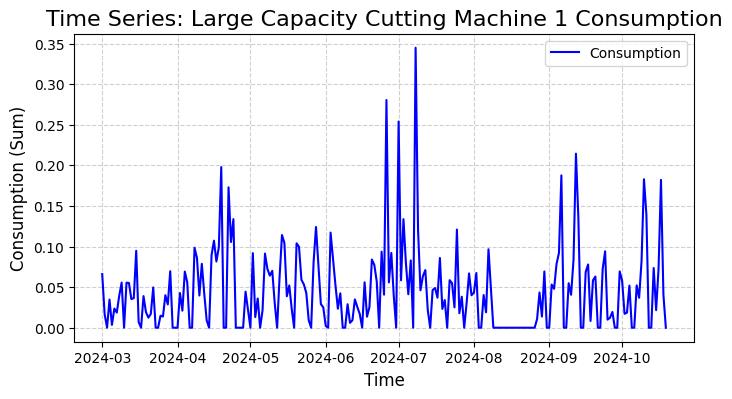

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the time series
time_series = data.loc[
    (data['name'] == 'Large Capacity Cutting Machine 1') &
    (data['kpi'] == 'consumption'),
    ['time', 'sum']
]

# Make sure that the 'time' column is in datetime format
time_series['time'] = pd.to_datetime(time_series['time'])

# Set the 'time' column as the index
time_series.set_index('time', inplace=True)

# Convert 'sum' to numeric values if necessary
time_series['sum'] = pd.to_numeric(time_series['sum'], errors='coerce')

# Set frequency to daily
time_series = time_series.asfreq('D')

# Plot of the time series
plt.figure(figsize=(8, 4))
plt.plot(time_series.index, time_series['sum'], label='Consumption', color='blue', linewidth=1.5)
plt.title('Time Series: Large Capacity Cutting Machine 1 Consumption', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Consumption (Sum)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
# preprocess the time series to obtain the best_decomposition
best_decomposition, selected_f, inconsistencies_flag, h_trend_drift, time_series = preprocess_h_data(time_series['sum'])

Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected

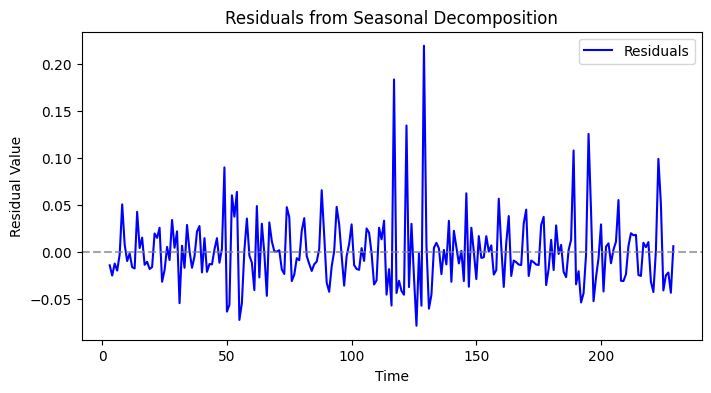

In [ ]:
# Plot of the residuals
plt.figure(figsize=(8, 4))
plt.plot(best_decomposition.resid, label='Residuals', color='blue')
plt.axhline(0, linestyle='--', color='gray', alpha=0.7)
plt.title("Residuals from Seasonal Decomposition")
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

### Isolation forest function

In [ ]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import matplotlib.pyplot as plt

def detect_anomalies_from_decomposition(decomposition, contamination="auto", plot_flag=True):
    """
    Detect anomalies using residuals from seasonal decomposition.

    Parameters:
    - decomposition: Result of seasonal decomposition (trend, seasonality, residuals).
    - contamination: Proportion of anomalies in the dataset for Isolation Forest.
    - plot_flag: If True, plots the anomalies on the residual series.

    Returns:
    - anomalies: DataFrame with detected anomalies.
    - iso_forest: Trained model for anomaly detection.
    """

    # Extract residuals, remove NaN values, and reset index
    residuals = pd.Series(decomposition.resid).dropna()#.reset_index(drop=True)
    residuals.index += 1  # Start indices from 1

    # Create a DataFrame for the residuals
    residual_df = pd.DataFrame({'residuals': residuals})

    # Apply Isolation Forest for anomaly detection
    iso_forest = IsolationForest(contamination=contamination, random_state=1)  # Random state for reproducibility
    residual_df['anomaly'] = iso_forest.fit_predict(residual_df[['residuals']])
    residual_df['anomaly'] = residual_df['anomaly'].map({1: 0, -1: 1})  # Map 1 to anomaly, 0 to normal

    # Extract anomalies
    anomalies = residual_df[residual_df['anomaly'] == 1]['residuals']
    anomaly_indices = anomalies.index

    # Plot anomalies if requested
    if plot_flag:
        plt.figure(figsize=(8, 4))
        plt.plot(residual_df.index, residual_df['residuals'], label='Residuals', color='blue')
        plt.scatter(
            anomaly_indices,
            residual_df.loc[anomaly_indices, 'residuals'],
            color='red', label='Anomalies', zorder=5
        )
        plt.title("Anomaly Detection Based on Residuals")
        plt.xlabel("Index")
        plt.ylabel("Residual Value")
        plt.legend()
        plt.show()

    return anomalies, iso_forest

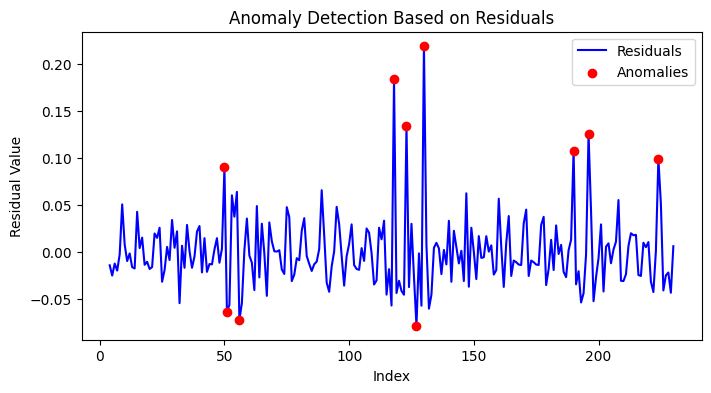

In [ ]:
anomalies, iso_forest = detect_anomalies_from_decomposition(best_decomposition, contamination = 0.04, plot_flag = True)

We are supposing to have a dataframe saved in the feature store with the decomposition struct associated to each [machine, kpi, col] tuple

### Model training on historical data

In [ ]:
feat_data.head()

,name,kpi,col,selected_f,unusable_data_bool,inconsistencies_flag,h_trend_drift,best_decomposition,count_miss_values,time_series
0,Large Capacity Cutting Machine 1,working_time,sum,7,False,False,2.015545,"{'trend': [0.959794602693685, 0.58710055595157...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.46035297630689376, 0.9902567679067752, 0.43..."
1,Large Capacity Cutting Machine 1,working_time,avg,7,False,False,-0.372757,"{'trend': [0.19179658711554515, 0.557069925690...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8186451015893835, 0.9104366443110137, 0.830..."
2,Large Capacity Cutting Machine 1,working_time,min,7,True,False,-0.167134,"{'trend': [0.19657465206051006, 0.066503445505...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.024836400684480897, 0.4462919500473709, 0.3..."
3,Large Capacity Cutting Machine 1,working_time,max,30,False,False,0.108373,"{'trend': [0.776538021882832, 0.09953289929242...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.34130249517921707, 0.08072610850618445, 0.3..."
4,Large Capacity Cutting Machine 1,idle_time,sum,7,True,True,0.472236,"{'trend': [0.4183455462705572, 0.6408264245881...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.23654807882406403, 0.31473621292554765, 0.6..."


In [ ]:
# Extracting the decomposition for each combination
for name in feat_data['name'].unique():
    for k in feat_data['kpi'].unique():
        for col in feat_data['col'].unique():
            # Filter the dataframe to get the corresponding row
            row = feat_data[(feat_data['name'] == name) &
                                   (feat_data['kpi'] == k) &
                                   (feat_data['col'] == col)]

            # Extract the 'decomposition' from the row
            decomposition = row['best_decomposition'].values[0]

            # Pass the decomposition to the detect anomalies function
            anomalies, iso_forest = detect_anomalies_from_decomposition(decomposition, contamination = 0.04)


### we still need to understand how to save the models iso_forest and anomalies

AttributeError: 'dict' object has no attribute 'resid'

### Anomaly Detection on streaming data

The idea is to use the trained models to detect if the difference between prediction and actual value is too high

In [ ]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# Assume iso_forest is a pre-trained Isolation Forest model
# and current_value and predicted_value are your current data points.

# Function to detect anomalies on streaming data
def detect_anomalies_from_streaming_data(prediction_error, iso_forest):
    """
    Detects anomalies in streaming data using Isolation Forest.

    Parameters:
    - prediction_error: The difference between the actual and predicted values (residual).
    - iso_forest: A pre-trained Isolation Forest model.

    Returns:
    - anomaly: 1 if the current data point is an anomaly, 0 if it is normal.
    """

    # Convert the prediction_error into a DataFrame for the model
    prediction_error_df = pd.DataFrame([prediction_error], columns=['residuals'])

    # Use the Isolation Forest model to predict anomaly
    anomaly_bool = iso_forest.predict(prediction_error_df)

    # Convert the numpy array to a pandas Series before using .map()
    anomaly_bool = pd.Series(anomaly_bool).map({1: 0, -1: 1})

    if anomaly_bool == 1:
      send_warning('Anomaly_streaming', ' an anomaly has been detected in the streaming data')

    # Return 1 for anomaly, 0 for normal
    return anomaly_bool[0]

In [ ]:
# required inputs
current_value = None
predicted_value = None
iso_forest

# Compute the prediction error
prediction_error = current_value - predicted_value

# Anomaly detection on streaming data
anomaly_bool = detect_anomalies_from_streaming_data(prediction_error, iso_forest)


In [ ]:
# CREATION OF ONLINE FEATURE STORE, CALLED FEAT_s_DATA
from itertools import product

# Valori unici per ogni colonna
names = data['name'].unique()
kpis = data['kpi'].unique()
cols = ['sum', 'avg', 'min', 'max']

# Genera tutte le combinazioni possibili
combinations = list(product(names, kpis, cols))

# Crea un DataFrame a partire dalle combinazioni
feat_s_data = pd.DataFrame(combinations, columns=['name', 'kpi', 'col'])

# Aggiungi le altre colonne con valori casuali
feat_s_data['current_value'] = np.random.normal(0, 1, len(feat_data))
feat_s_data['predicted_value'] = np.random.normal(0, 1, len(feat_data))
feat_s_data['iso_forest'] = [iso_forest for _ in range(len(feat_data))]
feat_s_data['trend_drift'] = [(bool(np.random.choice([0, 1])), round(np.random.uniform(-1, 1), 4)) for _ in range(len(feat_data))]


# Mostra le prime righe del DataFrame
feat_s_data.head()

In [ ]:
#trial
for name in feat_s_data['name'].unique():
    for k in feat_s_data['kpi'].unique():
        for col in feat_s_data['col'].unique():
          current_value = feat_s_data[(feat_s_data['name'] == name) & (feat_s_data['kpi'] == k) & (feat_s_data['col'] == col)]['current_value'].iloc[0]
          predicted_value = feat_s_data[(feat_s_data['name'] == name) & (feat_s_data['kpi'] == k) & (feat_s_data['col'] == col)]['predicted_value'].iloc[0]
          iso_forest = feat_s_data[(feat_s_data['name'] == name) & (feat_s_data['kpi'] == k) & (feat_s_data['col'] == col)]['iso_forest'].iloc[0]
          prediction_error = current_value - predicted_value
          anomaly_bool = detect_anomalies_from_streaming_data(prediction_error, iso_forest)
          # anomaly bool to be stored

### Integration of multiple KPI anomalies

integration of multiple kpi to understand the well being of the entire machine.
simple kpi:

 Time-related	KPIs (relativi	al	tempo):
 * working_time:	tempo	in	cui	la	macchina	è	operativa	(in	secondi).
 * idle_time:	tempo	in	cui	la	macchina	è	accesa	ma	inattiva	(in	secondi).
 * offline_time:	tempo	in	cui	la	macchina	è	spenta	o	fuori	linea	(in	secondi).

 Energy	and	Cost-related	KPIs (relativi	a	energia	e	costi):
 * consumption:	consumo	totale	di	energia	della	macchina	(in	kWh).
 * power:	potenza	assorbita	in	tempo	reale	(in	kW).
 * cost:	costo	per	kWh	consumato	(in	euro).
 * consumption_working:	consumo	energetico	durante	il	tempo	di	attività	(in	kWh).
 * consumption_idle:	consumo	energetico	durante	il	tempo	di	inattività	(in	kWh).

 Production-related	KPIs (relativi	alla	produzione):
 * cycles:	numero	totale	di	cicli	completati	dalla	macchina.
 * good_cycles:	numero	di	cicli	riusciti	o	di	buona	qualità.
 * bad_cycles:	numero	di	cicli	difettosi	o	scartati.
 * average_cycle_time:	tempo	medio	per	ogni	ciclo	completato	(in	secondi)

3 requirements:

*   detect anomalies in production performance
*   detect anomalies in energy consumption
*   detect anomalies in machine status  


In [ ]:
# integration of multiple kpi

# given n kpi (simple of complex):
feat_s_data['kpi'].unique()

# create a dictionary for the concept drifts
concept_drifts = {kpi: 0 for kpi in feat_s_data['kpi'].unique()}

# updating the values for the concept drifts ---> DEPENDS ON THE DATABASE STORAGE AND ON HOW WE SAVE THE FEATURES
# proposed: use trend_drift_bool[0] for trend drift and sign od trend_drift_bool[1] for +-1

# trend_drift from online feature store!

for name in feat_s_data['name'].unique():
    for k in feat_s_data['kpi'].unique():
        for col in feat_s_data['col'].unique():
          trend_drift = feat_s_data[(feat_s_data['name'] == name) & (feat_s_data['kpi'] == k) & (feat_s_data['col'] == col)]['trend_drift'].iloc[0]
          if trend_drift[0]: # of that kpi!
            if trend_drift[1] > 0:
              concept_drifts[k] = 1
            else:
              concept_drifts[k] = -1
          else:
            concept_drifts[k] = 0

            # to be stored in online feature store

In [ ]:
concept_drifts

{'working_time': 1,
 'idle_time': 1,
 'offline_time': -1,
 'consumption': 0,
 'power': 0,
 'consumption_working': 0,
 'consumption_idle': 0,
 'cost': 0,
 'cost_working': -1,
 'cost_idle': 0,
 'cycles': 1,
 'good_cycles': 1,
 'bad_cycles': 0,
 'average_cycle_time': 0}

In [ ]:
# rules for the integration
rules = [
    {"condition": {"cycles": 1, "energy_consumption": 1}, "status": "Producing more"},
    {"condition": {"cycles": 1, "energy_consumption": -1}, "status": "Producing more efficiently consuming less energy"},
    {"condition": {"cycles": -1, "energy_consumption": 1}, "status": "Consuming more with less production"},
    {"condition": {"cycles": -1, "energy_consumption": -1}, "status": "Producing less but conserving energy"},
    {"condition": {"working_time": 1, "idle_time": 1}, "status": "Working and idle time are high. Check for inefficiency."},
    {"condition": {"working_time": -1, "idle_time": -1}, "status": "Low working and idle time. Possible downtime."},
    {"condition": {"consumption_working": 1, "consumption_idle": -1}, "status": "High consumption during working time, low idle consumption."},
    {"condition": {"consumption_working": -1, "consumption_idle": 1}, "status": "Low consumption during working time, high idle consumption."},
    {"condition": {"cycles": 1, "bad_cycles": -1}, "status": "Increase in good cycles, low bad cycles. Optimized production."},
    {"condition": {"cycles": -1, "bad_cycles": 1}, "status": "Decrease in good cycles, increase in bad cycles. Quality issue."},
    {"condition": {"power": 1, "working_time": 1}, "status": "High power usage during working time, investigate for inefficiency."},
    {"condition": {"power": -1, "working_time": -1}, "status": "Low power usage with reduced working time, possible machine underuse."},
    {"condition": {"cost_working": 1, "cost_idle": -1}, "status": "Higher cost during working time than idle. Efficiency issues."},
    {"condition": {"cost_working": -1, "cost_idle": 1}, "status": "Cost-efficient idle time compared to working time."},
    {"condition": {"bad_cycles": 1, "good_cycles": -1}, "status": "High bad cycles, low good cycles. Possible process malfunction."},
    {"condition": {"average_cycle_time": 1, "good_cycles": -1}, "status": "Increase in cycle time, decrease in good cycles. Investigate quality."},
    {"condition": {"working_time": 1, "cost": 1}, "status": "High working time, high cost. Review productivity."},
    {"condition": {"working_time": -1, "cost": -1}, "status": "Low working time and low cost. Possibly under-utilized."},
    {"condition": {"offline_time": 1, "working_time": -1}, "status": "Increase in offline time, decrease in working time. Unplanned downtime."},
    {"condition": {"cycles": 1, "power": 1}, "status": "Higher cycles and power usage, check for energy inefficiencies."},
    {"condition": {"cycles": -1, "power": -1}, "status": "Fewer cycles and lower power usage, could indicate production slowdown."},
    {"condition": {"cost_idle": 1, "idle_time": 1}, "status": "High cost during idle time, investigate machine settings."},
    {"condition": {"cost_idle": -1, "idle_time": -1}, "status": "Low cost during idle time, optimal energy savings."},
    {"condition": {"consumption": 1, "cost": 1}, "status": "Increase in both consumption and cost, possible inefficiency."},
    {"condition": {"consumption": -1, "cost": -1}, "status": "Decrease in both consumption and cost, potential energy savings."}
]


In [ ]:
def evaluate_machine_status(concept_drifts, rules):
    """
    Valuta lo stato generale di una macchina basandosi sui concept drift dei KPI.

    Parameters:
    - concept_drifts: Dizionario in cui le chiavi sono i KPI e i valori sono i concept drift (+1 per positivo, -1 per negativo, 0 per neutrale).
      Esempio: {"cycles": 1, "energy_consumption": -1}
    - rules: Lista di regole che mappano i concept drift a stati generali della macchina.
      Esempio:
      [
          {"condition": {"cycles": 1, "energy_consumption": 1}, "status": "Producing more"},
          {"condition": {"cycles": -1, "energy_consumption": 1}, "status": "Inefficient"}
      ]

    Returns:
    - machine_status: Stato generale della macchina determinato dalle regole.
    """
    for rule in rules:
        condition = rule["condition"]
        if all(concept_drifts.get(kpi, 0) == condition.get(kpi, 0) for kpi in condition):
            return rule["status"]

    return "Unknown behavior"  # Stato di default se nessuna regola è soddisfatta


In [ ]:
# Valutazione dello stato della macchina

machine_status = evaluate_machine_status(concept_drifts, rules)
print(f"Machine Status: {machine_status}")

Machine Status: Working and idle time are high. Check for inefficiency.


# Processing: Performance prediction

### Reference time series


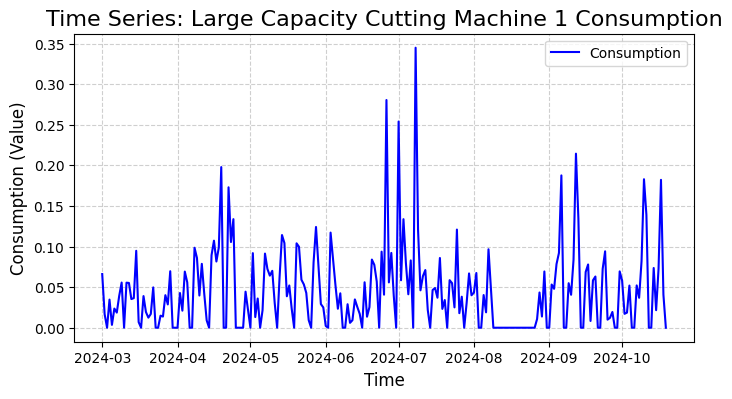

In [ ]:
# Filter the time series
time_series = data.loc[
    (data['name'] == 'Large Capacity Cutting Machine 1') &
    (data['kpi'] == 'consumption'),
    ['time', 'sum']
]

# Make sure that the 'time' column is in datetime format
time_series['time'] = pd.to_datetime(time_series['time'])

# Set the 'time' column as the index
time_series.set_index('time', inplace=True)

# Convert 'sum' to numeric values if necessary
time_series['sum'] = pd.to_numeric(time_series['sum'], errors='coerce')

# Rename the 'sum' column to 'value'
time_series.rename(columns={'sum': 'value'}, inplace=True)

# Set frequency to daily
time_series = time_series.asfreq('D')

# Plot of the time series
plt.figure(figsize=(8, 4))
plt.plot(time_series.index, time_series['value'], label='Consumption', color='blue', linewidth=1.5)
plt.title('Time Series: Large Capacity Cutting Machine 1 Consumption', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Consumption (Value)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [ ]:
# Make sure the time series is ordered and has no missing values
time_series = time_series.dropna()
time_series = time_series.sort_index()

# Split the time series into training, validation, and test sets
train_size = int(len(time_series) * 0.7)
val_size = int(len(time_series) * 0.2)
test_size = len(time_series) - train_size - val_size

train = time_series.iloc[:train_size]
validation = time_series.iloc[train_size:train_size + val_size]
test = time_series.iloc[train_size + val_size:]

print(f"Training data shape: {train.shape}")
print(f"Validation data shape: {validation.shape}")
print(f"Test data shape: {test.shape}")

Training data shape: (163, 1)
Validation data shape: (46, 1)
Test data shape: (24, 1)


### SARIMA model

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to check number of differentiations needed to obtain stationarity (parameter d of SARIMA)
def adf_test(time_series):
    time_series = time_series.copy()
    d = 0
    while True:
        result = adfuller(time_series)
        p_value = result[1]  # p-value is the second element in the result tuple
        if p_value <= 0.05:  # The series is stationary
            break
        else:  # The series is not stationary --> difference the series
            time_series = time_series.diff().dropna()
            d += 1
        if d > 5:  # Arbitrary limit to avoid infinite loop
            print("Max differentiation reached, series may not be stationary")
            break
    return d

In [ ]:
## SARIMAX WITH AIC
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


# Stationarity test on the training set
d = adf_test(train)
D = 0  # Seasonal differencing
s = 7  # Seasonal period

# Search for the best SARIMAX parameters using the validation set
best_aic = float('inf')
best_order = None
best_seasonal_order = None

for p in range(1, 5):
    for q in range(1, 5):
        for P in range(1, 3):
            for Q in range(1, 3):
                try:
                    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s),
                                    enforce_stationarity=False, enforce_invertibility=False)
                    results = model.fit(disp=False)
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, q)
                        best_seasonal_order = (P, Q)
                except Exception as e:
                    print(f"Error: {e}")
                    continue

print(f"Best AIC: {best_aic}")
print(f"Best order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

# Train the final model on the training + validation set
final_train = pd.concat([train, validation])
p, q = best_order
P, Q = best_seasonal_order

final_model = SARIMAX(final_train, order=(p, d, q), seasonal_order=(P, D, Q, s),
                      enforce_stationarity=False, enforce_invertibility=False)
final_results = final_model.fit(disp=False)

# Model summary
print(final_results.summary())

# Forecast on the test data
forecast = final_results.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train', color='blue')
plt.plot(validation, label='Validation', color='green')
plt.plot(test, label='Test', color='red')
plt.plot(forecast.predicted_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.2)
plt.title('SARIMAX Forecast with Train/Validation/Test Split')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.grid()
plt.show()


KeyboardInterrupt: 

In [ ]:
## SARIMAX WITH RMSE
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error


# Stationarity test on the training set
d = adf_test(train)
D = 0  # Seasonal differencing
s = 7  # Seasonal period

# Search for the best SARIMAX parameters using RMSE on the validation set
best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for p in range(1, 5):
    for q in range(1, 5):
        for P in range(1, 3):
            for Q in range(1, 3):
                try:
                    # Train the model on the training set
                    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s),
                                    enforce_stationarity=False, enforce_invertibility=False)
                    results = model.fit(disp=False)

                    # Forecast on the validation set
                    val_forecast = results.get_prediction(start=validation.index[0], end=validation.index[-1])
                    val_predicted = val_forecast.predicted_mean

                    # Compute the Root Mean Squared Error (RMSE)
                    rmse = np.sqrt(mean_squared_error(validation, val_predicted))

                    # Update the best parameters if RMSE is lower
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p, q)
                        best_seasonal_order = (P, Q)

                except Exception as e:
                    print(f"Error with order ({p}, {q}) and seasonality ({P}, {Q}): {e}")
                    continue

print(f"Best RMSE: {best_rmse}")
print(f"Best order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

# Train the final model on the training + validation set
final_train = pd.concat([train, validation])
p, q = best_order
P, Q = best_seasonal_order

final_model = SARIMAX(final_train, order=(p, d, q), seasonal_order=(P, D, Q, s),
                      enforce_stationarity=False, enforce_invertibility=False)
final_results = final_model.fit(disp=False)

# Model summary
print(final_results.summary())

# Forecast on the test data
forecast = final_results.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train', color='blue')
plt.plot(validation, label='Validation', color='green')
plt.plot(test, label='Test', color='red')
plt.plot(forecast.predicted_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.2)
plt.title('SARIMAX Forecast with Train/Validation/Test Split')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.grid()
plt.show()


### FFNN model

In [ ]:
def forecast_with_ffnn(
    time_series, n_lags=14, hidden_units_options=[32, 64, 128], epochs=50, batch_size=16, seed=0, plot_results=True
):
    # Set seed for reproducibility
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

    # Make sure the time series is ordered and has no missing values
    time_series = time_series.dropna()
    time_series = time_series.sort_index()

    # Split the time series into training, validation, and test sets
    train_size = int(len(time_series) * 0.7)
    val_size = int(len(time_series) * 0.2)
    test_size = len(time_series) - train_size - val_size

    train = time_series.iloc[:train_size]
    validation = time_series.iloc[train_size:train_size + val_size]
    test = time_series.iloc[train_size + val_size:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    validation_scaled = scaler.transform(validation)
    test_scaled = scaler.transform(test)
    train_val_scaled = np.vstack([train_scaled, validation_scaled])

    # Prepare the data
    def prepare_data(series, n_lags):
        series = np.array(series)
        X = np.lib.stride_tricks.sliding_window_view(series, window_shape=n_lags)[:-1]
        y = series[n_lags:]
        return X, y

    X_train_val, y_train_val = prepare_data(train_val_scaled.flatten(), n_lags)
    X_test, y_test = prepare_data(test_scaled.flatten(), n_lags)

    # Split train and validation
    split_idx = len(train)
    X_train, y_train = X_train_val[:split_idx-n_lags], y_train_val[:split_idx-n_lags]
    X_val, y_val = X_train_val[split_idx-n_lags:], y_train_val[split_idx-n_lags:]

    # Reshape data
    X_train = X_train.reshape(X_train.shape[0], n_lags)
    X_val = X_val.reshape(X_val.shape[0], n_lags)
    X_test = X_test.reshape(X_test.shape[0], n_lags)

    # Hyperparameter tuning
    best_rmse = float('inf')
    best_units = None
    for units in hidden_units_options:
        model = Sequential([
            Dense(units, activation='relu', input_dim=n_lags),
            Dense(units // 2, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        y_val_pred = model.predict(X_val).ravel()
        y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1)).ravel()
        y_val_pred_rescaled = scaler.inverse_transform(y_val_pred.reshape(-1, 1)).ravel()
        rmse = np.sqrt(mean_squared_error(y_val_rescaled, y_val_pred_rescaled))

        if rmse < best_rmse:
            best_rmse = rmse
            best_units = units

    # Final model training
    model = Sequential([
        Dense(best_units, activation='relu', input_dim=n_lags),
        Dense(best_units // 2, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_val, y_train_val, epochs=epochs, batch_size=batch_size, verbose=0)

    # Predictions
    y_test_pred = model.predict(X_test).ravel()
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_test_pred_rescaled = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()

    # Sliding window predictions
    predictions = []
    input_seq = X_test[0]
    for _ in range(len(test)):
        pred = model.predict(input_seq.reshape(1, -1), verbose=0)[0, 0]
        predictions.append(pred)
        input_seq = np.append(input_seq[1:], pred)

    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Residuals and confidence interval
    residuals = y_test_rescaled.flatten() - y_test_pred_rescaled
    std_residuals = np.std(residuals)
    confidence_interval = (predictions_rescaled - 2 * std_residuals, predictions_rescaled + 2 * std_residuals)

    # Plot results
    if plot_results:
        plt.figure(figsize=(8, 4))
        plt.plot(pd.to_datetime(time_series.index), time_series['value'], label='Full Series', color='gray', linestyle='--', alpha=0.5)
        plt.plot(pd.to_datetime(train.index), train['value'], label='Train', color='blue')
        plt.plot(pd.to_datetime(validation.index), validation['value'], label='Validation', color='green')
        plt.plot(pd.to_datetime(test.index), test['value'], label='Test', color='red')
        plt.plot(pd.to_datetime(test.index), predictions_rescaled, label='Forecast', color='orange')
        plt.fill_between(
            test.index,
            predictions_rescaled - 2 * std_residuals,
            predictions_rescaled + 2 * std_residuals,
            color='orange', alpha=0.2, label='Confidence Interval'
        )
        plt.title('FFNN Forecast with Train, Validation, Test, and Confidence Interval')
        plt.xlabel('Time')
        plt.ylabel('Consumption')
        plt.legend()
        plt.grid()
        plt.show()

    return model, scaler


### Model training on historical data

Here we are training the prediction models ( using FFNN ) for the time series associated to the selected KPIs and machines

In [ ]:
# Extracting the time_series for each combination
for name in feat_data['name'].unique():
    for k in feat_data['kpi'].unique():
        for col in feat_data['col'].unique():
            # Filter the dataframe to get the corresponding row
            time_series = feat_data[(feat_data['name'] == name) &
                                   (feat_data['kpi'] == k) &
                                   (feat_data['col'] == col)]['time_series']
            time_series = pd.DataFrame({'value': time_series.tolist()[0]}, index = data['time'].unique())

            # Pass the time_series to the detect anomalies function
            trained_ffnn = forecast_with_ffnn(time_series)

### Prediction of future values

Here we use the trained model to predict the future values \
The function is called once a day when we receive the new data, and the new predictions will substitute the previous ones

In [ ]:
def forecast_future(time_series, trained_ffnn, scaler, n_future = 21, n_lags = 14, plot_results=True):
    """
    Forecast future values of the time series using the trained FFNN model.

    Parameters:
    - time_series (pd.Series): The input time series.
    - trained_ffnn (tensorflow.keras.models.Sequential): The trained FFNN model.
    - scaler (sklearn.preprocessing.MinMaxScaler): The scaler used to scale the data.
    - n_future (int): The number of future values to predict.
    - n_lags (int): The number of lags (time window) for the prediction. N.B. must be the same of training function
    - plot_results (bool): Whether to plot the results.

    Returns:
    - predictions_rescaled (numpy.array): An array containing the future predictions.
    """

    if len(time_series) >= n_lags:

      # Extract the last sequence of n_lags from the time series
      last_sequence = time_series[-n_lags:].values.reshape(1, -1)  # Last n_lags values

      predictions = []
      input_seq = last_sequence.flatten()

      # Standard deviation of residuals for uncertainty
      residuals = time_series[-n_lags:].values - trained_ffnn.predict(input_seq.reshape(1, -1), verbose=0).flatten()
      std_residuals = np.std(residuals)

      # Predict the future values
      for _ in range(n_future):
          # Predict the next value
          pred = trained_ffnn.predict(input_seq.reshape(1, -1), verbose=0)[0, 0]
          predictions.append(pred)

          # Add the prediction to the input sequence for the next step
          input_seq = np.append(input_seq[1:], pred)

      # Rescale the predictions back to the original scale
      predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

      # Confidence interval (± 2 standard deviations)
      confidence_interval_lower = predictions_rescaled - 2 * std_residuals
      confidence_interval_upper = predictions_rescaled + 2 * std_residuals

      # Plot the results
      if plot_results:
          plt.figure(figsize=(8, 4))
          plt.plot(pd.to_datetime(time_series.index), time_series.values, label='Original Series', color='gray', linestyle='--', alpha=0.5)
          future_dates = pd.date_range(pd.to_datetime(time_series.index[-1]), periods=n_future + 1, freq='D')[1:]
          plt.plot(future_dates, predictions_rescaled, label='Forecast', color='orange')
          plt.fill_between(future_dates, confidence_interval_lower, confidence_interval_upper,
                          color='orange', alpha=0.2, label='Confidence Interval')
          plt.title('FFNN Forecast with Confidence Interval')
          plt.xlabel('Time')
          plt.ylabel('Value')
          plt.legend()
          plt.grid()
          plt.show()
    else:
      print('Time series length not sufficient to perform prediction')

    return predictions_rescaled


In [ ]:
# Extracting the time_series for each combination
for name in feat_data['name'].unique():
    for k in feat_data['kpi'].unique():
        for col in feat_data['col'].unique():
            # Filter the dataframe to get the corresponding row
            time_series = feat_data[(feat_data['name'] == name) &
                                   (feat_data['kpi'] == k) &
                                   (feat_data['col'] == col)]['time_series']
            time_series = pd.DataFrame({'value': time_series.tolist()[0]}, index = data['time'].unique())
            trained_ffnn = feat_s_data[(feat_s_data['name'] == name) & (feat_s_data['kpi'] == k) & (feat_s_data['col'] == col)]['trained_ffnn'].iloc[0]
            scaler = feat_s_data[(feat_s_data['name'] == name) & (feat_s_data['kpi'] == k) & (feat_s_data['col'] == col)]['scaler'].iloc[0]

            # Pass the time_series to the predict future values
            predicted_values = forecast_future(time_series, trained_ffnn, scaler)

            ## remember to save the predicted values in place of the previous ones in the database
            ## for the integration part could be possible to substitute the complete time_series with only an array containing
            ## the last n_lags values of it saved in the feat_s_data


### Example of training + prediction

In [ ]:
trained_ffnn, scaler = forecast_with_ffnn(time_series)

In [ ]:
# Number of future values to predict
n_future = 21

# Call the function to forecast the future values
predicted_values = forecast_future(time_series, trained_ffnn, scaler, n_future)

# Demo (single time series pipeline)

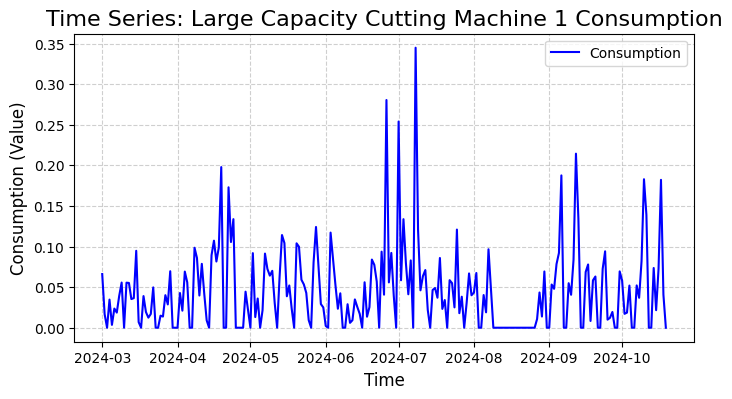

In [ ]:
# Filter the time series
time_series = data.loc[
    (data['name'] == 'Large Capacity Cutting Machine 1') &
    (data['kpi'] == 'consumption'),
    ['sum']
]

time_series = pd.DataFrame({'value': time_series['sum'].tolist()}, index = data['time'].unique())

# Plot of the time series
plt.figure(figsize=(8, 4))
plt.plot(pd.to_datetime(time_series.index), time_series['value'], label='Consumption', color='blue', linewidth=1.5)
plt.title('Time Series: Large Capacity Cutting Machine 1 Consumption', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Consumption (Value)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
# Filter the time series
time_series = data.loc[
    (data['name'] == 'Large Capacity Cutting Machine 1') &
    (data['kpi'] == 'consumption'),
    'sum'
]
# Preprocessing
best_decomposition, selected_f, inconsistencies_flag, h_trend_drift, pp_time_series = preprocess_h_data(time_series)

Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift is negative
Trend drift detected

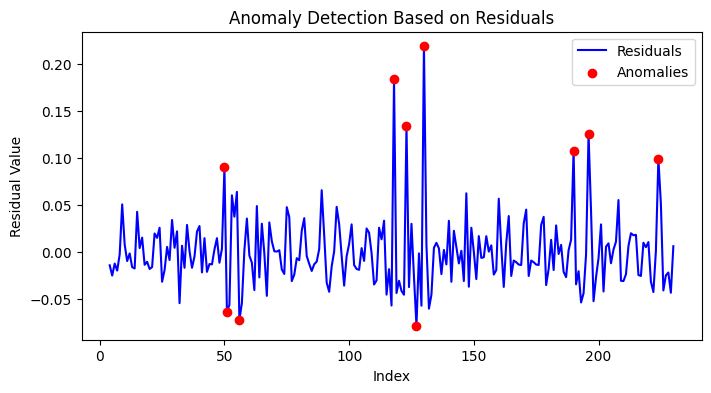

In [ ]:
# Anomaly detection
anomalies, iso_forest = detect_anomalies_from_decomposition(best_decomposition, contamination = 0.04)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


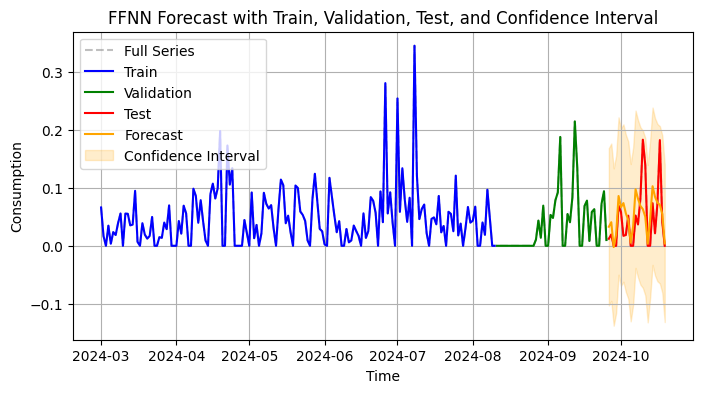

In [ ]:
# Prediction
pp_time_series = pd.DataFrame({'value': pp_time_series.tolist()}, index = data['time'].unique())
trained_ffnn, scaler = forecast_with_ffnn(pp_time_series)

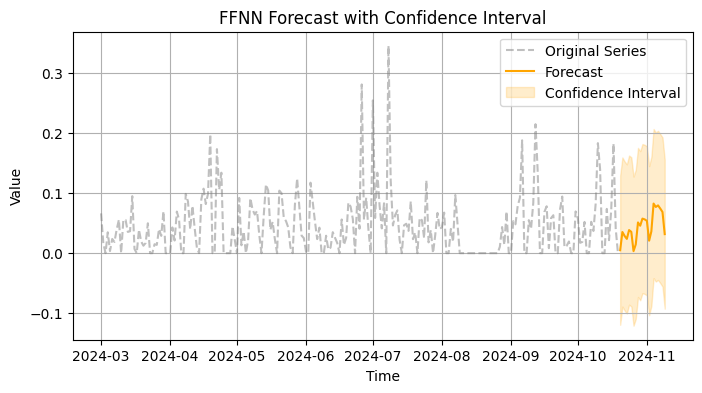

In [ ]:
# Prediction of future values
n_future = 21
predicted_values = forecast_future(pp_time_series, trained_ffnn, scaler, n_future)

## example: kpi integration for machine evaluation (last day)

In [ ]:
# Filter the time series

kpi_useful = ['working_time', 'idle_time', 'offline_time', 'consumption','consumption_working', 'consumption_idle', 'cost',
       'cost_working', 'cost_idle', 'cycles', 'good_cycles', 'bad_cycles']

# Create a dictionary for the concept drifts
concept_drifts = {kpi: 0 for kpi in kpi_useful}

for kpi in kpi_useful:
  time_series = data.loc[
    (data['name'] == 'Large Capacity Cutting Machine 1') &
    (data['kpi'] == kpi),
    'sum'
  ]
  best_decomposition, selected_f, inconsistencies_flag, h_trend_drift, pp_time_series = preprocess_h_data(time_series)

  if h_trend_drift['trend_drift_bool'].iloc[-1]: # of that kpi!
            if h_trend_drift['ks_stat'].iloc[-1] > 0:
              concept_drifts[kpi] = 1
            else:
              concept_drifts[kpi] = -1
  else:
    concept_drifts[kpi] = 0

Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected

In [ ]:
# rules for the integration
rules = [
    {"condition": {"cycles": 1, "energy_consumption": 1}, "status": "Producing more"},
    {"condition": {"cycles": 1, "energy_consumption": -1}, "status": "Producing more efficiently consuming less energy"},
    {"condition": {"cycles": -1, "energy_consumption": 1}, "status": "Consuming more with less production"},
    {"condition": {"cycles": -1, "energy_consumption": -1}, "status": "Producing less but conserving energy"},
    {"condition": {"working_time": 1, "idle_time": 1}, "status": "Working and idle time are high. Check for inefficiency."},
    {"condition": {"working_time": -1, "idle_time": -1}, "status": "Low working and idle time. Possible downtime."},
    {"condition": {"consumption_working": 1, "consumption_idle": -1}, "status": "High consumption during working time, low idle consumption."},
    {"condition": {"consumption_working": -1, "consumption_idle": 1}, "status": "Low consumption during working time, high idle consumption."},
    {"condition": {"cycles": 1, "bad_cycles": -1}, "status": "Increase in good cycles, low bad cycles. Optimized production."},
    {"condition": {"cycles": -1, "bad_cycles": 1}, "status": "Decrease in good cycles, increase in bad cycles. Quality issue."},
    {"condition": {"power": 1, "working_time": 1}, "status": "High power usage during working time, investigate for inefficiency."},
    {"condition": {"power": -1, "working_time": -1}, "status": "Low power usage with reduced working time, possible machine underuse."},
    {"condition": {"cost_working": 1, "cost_idle": -1}, "status": "Higher cost during working time than idle. Efficiency issues."},
    {"condition": {"cost_working": -1, "cost_idle": 1}, "status": "Cost-efficient idle time compared to working time."},
    {"condition": {"bad_cycles": 1, "good_cycles": -1}, "status": "High bad cycles, low good cycles. Possible process malfunction."},
    {"condition": {"average_cycle_time": 1, "good_cycles": -1}, "status": "Increase in cycle time, decrease in good cycles. Investigate quality."},
    {"condition": {"working_time": 1, "cost": 1}, "status": "High working time, high cost. Review productivity."},
    {"condition": {"working_time": -1, "cost": -1}, "status": "Low working time and low cost. Possibly under-utilized."},
    {"condition": {"offline_time": 1, "working_time": -1}, "status": "Increase in offline time, decrease in working time. Unplanned downtime."},
    {"condition": {"cycles": 1, "power": 1}, "status": "Higher cycles and power usage, check for energy inefficiencies."},
    {"condition": {"cycles": -1, "power": -1}, "status": "Fewer cycles and lower power usage, could indicate production slowdown."},
    {"condition": {"cost_idle": 1, "idle_time": 1}, "status": "High cost during idle time, investigate machine settings."},
    {"condition": {"cost_idle": -1, "idle_time": -1}, "status": "Low cost during idle time, optimal energy savings."},
    {"condition": {"consumption": 1, "cost": 1}, "status": "Increase in both consumption and cost, possible inefficiency."},
    {"condition": {"consumption": -1, "cost": -1}, "status": "Decrease in both consumption and cost, potential energy savings."}
]

In [ ]:
# Evaluation of the status of the machine
machine_status = evaluate_machine_status(concept_drifts, rules)
print(f"Machine Status: {machine_status}\n ")

print('Machine_status:')
print("-"*25)
for key, value in concept_drifts.items():
  print(f"{key}: {value}")

Machine Status: Low working and idle time. Possible downtime.
 
Machine_status:
-------------------------
working_time: -1
idle_time: -1
offline_time: -1
consumption: 0
consumption_working: 0
consumption_idle: 0
cost: -1
cost_working: -1
cost_idle: 0
cycles: 0
good_cycles: 0
bad_cycles: 0


## example: kpi integration for machine evaluation (example day 119)

In [ ]:
# Filter the time series

kpi_useful = ['working_time', 'idle_time', 'offline_time', 'consumption','consumption_working', 'consumption_idle', 'cost',
       'cost_working', 'cost_idle', 'cycles', 'good_cycles', 'bad_cycles']

# Create a dictionary for the concept drifts
concept_drifts = {kpi: 0 for kpi in kpi_useful}

for kpi in kpi_useful:
  time_series = data.loc[
    (data['name'] == 'Large Capacity Cutting Machine 1') &
    (data['kpi'] == kpi),
    'sum'
  ]
  best_decomposition, selected_f, inconsistencies_flag, h_trend_drift, pp_time_series = preprocess_h_data(time_series)

  if h_trend_drift['trend_drift_bool'].iloc[120]: # of that kpi!
            if h_trend_drift['ks_stat'].iloc[120] > 0:
              concept_drifts[kpi] = 1
            else:
              concept_drifts[kpi] = -1
  else:
    concept_drifts[kpi] = 0

Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift is positive
Trend drift detected

In [ ]:
# Evaluation of the status of the machine

machine_status = evaluate_machine_status(concept_drifts, rules)
print(f"Machine Status: {machine_status}\n ")

print('Machine_status:')
print("-"*25)
for key, value in concept_drifts.items():
  print(f"{key}: {value}")

Machine Status: Decrease in both consumption and cost, potential energy savings.
 
Machine_status:
-------------------------
working_time: 0
idle_time: 0
offline_time: 0
consumption: -1
consumption_working: -1
consumption_idle: 0
cost: -1
cost_working: -1
cost_idle: -1
cycles: 0
good_cycles: 0
bad_cycles: 0


# Others

### z-score for anomaly detection


In [ ]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

def test_gaussianity_shapiro(residuals):
    """
    Perform Shapiro-Wilk test for normality on the residuals and visualize the distribution.

    Parameters:
    - residuals: Residuals from seasonal decomposition.

    Returns:
    - p_value: P-value from the Shapiro-Wilk test.

    """
    # Shapiro-Wilk Test
    shapiro_stat, p_value = shapiro(residuals)

    # Visualization: Histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True, bins=20, color='blue', stat='density')
    plt.title("Residuals Histogram")
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.show()

    return p_value

In [ ]:
import numpy as np

def detect_anomalies_with_zscore(data, decomposition, col, z_threshold=2.0, plot_flag=True):
    """
    Detect anomalies using residuals from seasonal decomposition based on Z-Score.

    Parameters:
    - data: Original DataFrame with KPI data.
    - decomposition: Result of seasonal decomposition (trend, seasonality, residuals).
    - col: Column used in the decomposition (e.g., 'sum').
    - z_threshold: Threshold for Z-Score to classify an anomaly.
    - plot_flag: If True, plots the anomalies on the residual series.

    Returns:
    - anomalies: DataFrame with detected anomalies.
    - anomaly_indices: Indices of the anomalies in the dataset.
    """

    # Extract residuals and remove NaN values
    residuals = decomposition.resid.dropna()

    # Prepare residuals for anomaly detection
    residual_df = pd.DataFrame({col: residuals})
    residual_df['residuals'] = residual_df[col]

    # Calculate Z-Score
    mean_resid = residual_df['residuals'].mean()
    std_resid = residual_df['residuals'].std()
    residual_df['z_score'] = (residual_df['residuals'] - mean_resid) / std_resid

    # Detect anomalies based on Z-Score threshold
    residual_df['anomaly'] = (residual_df['z_score'].abs() > z_threshold).astype(int)

    # Get anomalies
    anomalies = residual_df[residual_df['anomaly'] == 1]
    anomaly_indices = anomalies.index

    # Plot anomalies on the residuals series
    if plot_flag:
        plt.figure(figsize=(12, 6))
        plt.plot(residual_df.index, residual_df['residuals'], label='Residuals', color='blue')
        plt.scatter(
            anomaly_indices,
            residual_df.loc[anomaly_indices, 'residuals'],
            color='red', label='Anomalies', zorder=5
        )
        plt.title(f"Anomaly Detection with Z-Score (Threshold: {z_threshold})")
        plt.legend()
        plt.show()

    return anomalies, anomaly_indices

# Esecuzione per Z-Score
for name in data['name'].unique()[1:2]:
    for k in kpi[10:11]:
        for col in data.columns[4:5]:
            plot_flag = True

            # Seasonal decomposition
            decomposition, _ = analysis_seasonality(data, name, k, col, freq_fin, plot_flag)

            # Test Gaussianity
            p_value = test_gaussianity_shapiro(decomposition.resid.dropna())

            print(f"Shapiro-Wilk Test p-value for {name} - {k}: {p_value}")
            if p_value < 0.05:
                print("Residuals are NOT normally distributed.")
            else:
                print("Residuals appear to be normally distributed.")

            # Detect anomalies with Z-Score
            anomalies, anomaly_indices = detect_anomalies_with_zscore(data, decomposition, col)

            print(f"Number of anomalies detected with Z-Score: {len(anomalies)}")
            print("Anomalies detected at the following indices:")
            print(anomaly_indices)
